<a href="https://colab.research.google.com/github/yuyaya2016/NFLSuperBowlPrediction/blob/master/NFLSuperBowl_ScorePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function

import math

from IPython import display
import matplotlib as mpl
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import sys
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset
from IPython import display
from six.moves import urllib

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False

# tf.random.set_seed(13)

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
%cd '/content/drive/My Drive/NFL/Data/'
#%ls '/content/drive/My Drive/NFL/Data/'

/content/drive/My Drive/NFL/Data


In [110]:
#import data
nfl = pd.read_excel('NFL_1619.xls', sheet_name='NFL_1619')
nfl.head()

,Team,Year,Week,Day,Date,Time,WinOrNot,OT,HomeField,Opp,Score_Tm,Score_Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO,ExpectedPoints_Offense,ExpectedPoints_Defense,ExpectedPoints_SpTms
0,Philadelphia Eagles,2019,1,Sun,2019-09-08,1:00PM ET,1,0,0,Washington Redskins,32,27,22,436,313,123,0,15,398,370,28,0,18.7,-12.1,0.6
1,Philadelphia Eagles,2019,2,Sun,2019-09-15,8:20PM ET,0,0,1,Atlanta Falcons,20,24,18,286,237,49,3,19,367,310,57,3,-3.2,-4.0,4.0
2,Philadelphia Eagles,2019,3,Sun,2019-09-22,1:00PM ET,0,0,0,Detroit Lions,24,27,22,373,246,127,2,16,287,201,86,0,-0.3,-1.1,-3.8
3,Philadelphia Eagles,2019,4,Thu,2019-09-26,8:20PM ET,1,0,1,Green Bay Packers,34,27,24,336,160,176,0,31,491,414,77,2,19.4,-16.9,4.1
4,Philadelphia Eagles,2019,5,Sun,2019-10-06,1:00PM ET,1,0,0,New York Jets,31,6,17,265,181,84,1,9,128,61,67,3,-4.6,34.6,-6.4


## Data Preprocessing

In [113]:
nfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2134 entries, 0 to 2133
Data columns (total 25 columns):
Team                      2134 non-null object
Year                      2134 non-null int64
Week                      2134 non-null object
Day                       2134 non-null object
Date                      2134 non-null datetime64[ns]
Time                      2134 non-null object
WinOrNot                  2134 non-null object
OT                        2134 non-null int64
HomeField                 2121 non-null object
Opp                       2134 non-null object
Score_Tm                  2134 non-null int64
Score_Opp                 2134 non-null int64
Offense_1stD              2134 non-null int64
Offense_TotYd             2134 non-null int64
Offense_PassY             2134 non-null int64
Offense_RushY             2134 non-null int64
Offense_TO                2134 non-null int64
Defense_1stD              2134 non-null int64
Defense_TotYd             2134 non-null int64
Def

In [114]:
nfl.describe()

,Year,OT,Score_Tm,Score_Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO,ExpectedPoints_Offense,ExpectedPoints_Defense,ExpectedPoints_SpTms
count,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0,2134.0
mean,2017.5,0.1,22.7,22.7,20.1,346.7,235.3,111.4,1.4,20.1,346.7,235.3,111.4,1.4,3.0,-3.0,-0.0
std,1.1,0.2,10.0,10.0,5.0,85.1,78.0,50.8,1.2,5.0,85.1,78.0,50.8,1.2,12.3,12.3,5.3
min,2016.0,0.0,0.0,0.0,5.0,89.0,6.0,6.0,0.0,5.0,89.0,6.0,6.0,0.0,-39.2,-42.7,-25.9
25%,2016.2,0.0,16.0,16.0,17.0,286.0,180.0,75.0,0.0,17.0,286.0,180.0,75.0,0.0,-4.9,-11.5,-3.4
50%,2017.0,0.0,23.0,23.0,20.0,345.0,232.0,103.0,1.0,20.0,345.0,232.0,103.0,1.0,3.2,-3.2,0.0
75%,2018.0,0.0,29.0,29.0,24.0,406.0,286.0,140.0,2.0,24.0,406.0,286.0,140.0,2.0,11.5,4.9,3.4
max,2019.0,1.0,59.0,59.0,37.0,643.0,500.0,323.0,8.0,37.0,643.0,500.0,323.0,8.0,42.7,39.2,25.9


In [115]:
#select columns
columns = ['Date', 'Team', 'Opp', 'WinOrNot',	'OT',	'HomeField', 'Score_Tm',	
            'Score_Opp',	'Offense_1stD',	'Offense_TotYd' ,'Offense_PassY',	
            'Offense_RushY',	'Offense_TO',	'Defense_1stD',	'Defense_TotYd',	
            'Defense_PassY',	'Defense_RushY',	'Defense_TO']
nfl_df = nfl[columns]
nfl_df.head()

,Date,Team,Opp,WinOrNot,OT,HomeField,Score_Tm,Score_Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
0,2019-09-08,Philadelphia Eagles,Washington Redskins,1,0,0,32,27,22,436,313,123,0,15,398,370,28,0
1,2019-09-15,Philadelphia Eagles,Atlanta Falcons,0,0,1,20,24,18,286,237,49,3,19,367,310,57,3
2,2019-09-22,Philadelphia Eagles,Detroit Lions,0,0,0,24,27,22,373,246,127,2,16,287,201,86,0
3,2019-09-26,Philadelphia Eagles,Green Bay Packers,1,0,1,34,27,24,336,160,176,0,31,491,414,77,2
4,2019-10-06,Philadelphia Eagles,New York Jets,1,0,0,31,6,17,265,181,84,1,9,128,61,67,3


In [116]:
#create team data
nfl_sf = nfl_df.query('Team =="San Francisco 49ers"')
nfl_ch = nfl_df.query('Team =="Kansas City Chiefs"')

nfl_sf.shape, nfl_ch.shape

((66, 18), (70, 18))

## Time Series Forecasting

`forecast offense and defense score for the next game`

In [0]:
#time series data
cols = ['Date', 'Score_Tm','Score_Opp', 'Offense_1stD', 'Offense_TotYd',
        'Offense_PassY', 'Offense_RushY', 'Offense_TO']

nfl_sf_ts = nfl_sf[cols].set_index('Date')
nfl_ch_ts = nfl_ch[cols].set_index('Date')

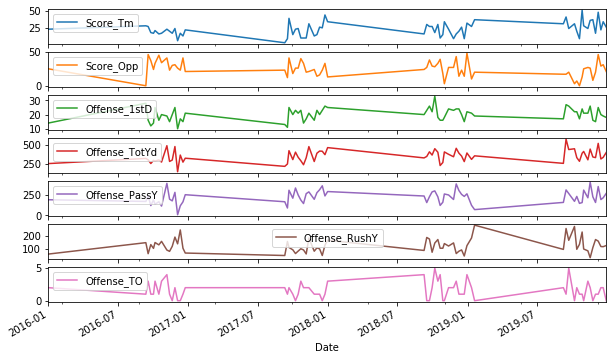

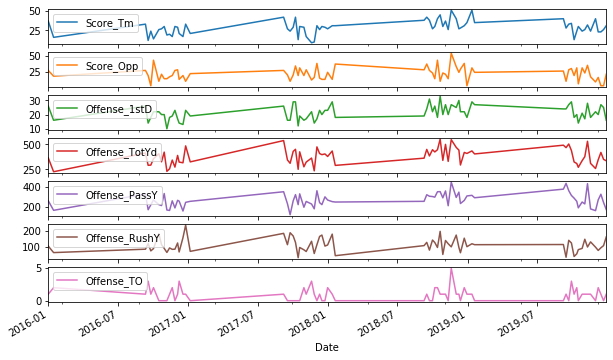

In [134]:
nfl_sf_ts.plot(subplots=True)
nfl_ch_ts.plot(subplots=True);

In [0]:
def get_train_data(data, target):
  train_data = data.query('Date >= "2019-09-01"')
  train_unidata = train_data[target]
  return train_unidata

# def get_val_data(data, target):
#    test_data = data.query('Date >= "2019-12-01"')
#    test_unidata = test_data[target]
#    return test_unidata

def standardize(df):  
  data = df.values
  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  data = (data - data_mean)/data_std
  return data

def inverse(df, arr):
  data = df.values
  data_mean = data.mean(axis=0)
  data_std = data.std(axis=0)
  inv_arr = arr * data_std + data_mean
  return inv_arr

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [120]:
target_list = ['Offense_1stD', 'Offense_TotYd', 'Offense_PassY', 'Offense_RushY', 'Offense_TO']

for i in target_list:
  train = get_train_data(nfl_sf_ts, i)
  train_st = standardize(train)
  tf.random.set_random_seed(1)
  TRAIN_SPLIT = 11
  univariate_past_history = 5
  univariate_future_target = 0

  x_train_uni, y_train_uni = univariate_data(train_st, 0, TRAIN_SPLIT,
                                            univariate_past_history,
                                            univariate_future_target)
  x_val_uni, y_val_uni = univariate_data(train_st, TRAIN_SPLIT, None,
                                        univariate_past_history,
                                        univariate_future_target)
  
  x_arr = inverse(train, x_train_uni[0])
  y = inverse(train, y_train_uni[0])
  
  print ('Single window of past history : {}'.format(x_arr))
  print ('\n Target temperature to predict : {}'.format(y))
  

Single window of past history : [[17.]
 [27.]
 [26.]
 [22.]
 [22.]]

 Target temperature to predict : 17.0
Single window of past history : [[256.]
 [571.]
 [436.]
 [446.]
 [331.]]

 Target temperature to predict : 283.0
Single window of past history : [[158.]
 [312.]
 [268.]
 [171.]
 [232.]]

 Target temperature to predict : 146.0
Single window of past history : [[ 98.]
 [259.]
 [168.]
 [275.]
 [ 99.]]

 Target temperature to predict : 137.0
Single window of past history : [[2.]
 [1.]
 [5.]
 [0.]
 [2.]]

 Target temperature to predict : 1.0


In [121]:
target_list = ['Offense_1stD', 'Offense_TotYd', 'Offense_PassY', 'Offense_RushY', 'Offense_TO']

for i in target_list:
  train = get_train_data(nfl_ch_ts, i)
  train_st = standardize(train)
  tf.random.set_random_seed(1)
  TRAIN_SPLIT = 11
  univariate_past_history = 5
  univariate_future_target = 0

  x_train_uni, y_train_uni = univariate_data(train_st, 0, TRAIN_SPLIT,
                                            univariate_past_history,
                                            univariate_future_target)
  x_val_uni, y_val_uni = univariate_data(train_st, TRAIN_SPLIT, None,
                                        univariate_past_history,
                                        univariate_future_target)
  
  x_arr = inverse(train, x_train_uni[0])
  y = inverse(train, y_train_uni[0])
  
  print ('Single window of past history : {}'.format(x_arr))
  print ('\n Target temperature to predict : {}'.format(y))
  

Single window of past history : [[24.]
 [24.]
 [27.]
 [29.]
 [18.]]

 Target temperature to predict : 20.0
Single window of past history : [[491.]
 [467.]
 [503.]
 [438.]
 [324.]]

 Target temperature to predict : 309.0
Single window of past history : [[378.]
 [436.]
 [363.]
 [315.]
 [288.]]

 Target temperature to predict : 256.0
Single window of past history : [[113.]
 [ 31.]
 [140.]
 [123.]
 [ 36.]]

 Target temperature to predict : 53.0
Single window of past history : [[0.]
 [1.]
 [0.]
 [3.]
 [1.]]

 Target temperature to predict : 2.0


In [0]:
['Offense_1stD', 'Offense_TotYd', 'Offense_PassY', 'Offense_RushY', 'Offense_TO']

nextgame_dic = {'Opp': ['Kansas City Chiefs', 'San Francisco 49ers'], 
          'Offense_1stD': [17.0, 20.0], 'Offense_TotYd': [283.0, 309.0],
          'Offense_PassY': [146.0, 256.0],	'Offense_RushY': [137.0,	53.0], 
          'Offense_TO': [1.0,	2.0], 'Defense_1stD': [20.0, 17.0],
          'Defense_TotYd':[309.0, 283.0], 'Defense_PassY': [146.0, 256.0], 
          'Defense_RushY': [53.0, 137.0], 'Defense_TO': [2.0, 1.0]}

next_game = pd.DataFrame.from_dict(nextgame_dic, orient = "index")
next_game = next_game.T
next_game['Score_Tm'] = 10
next_game.iloc[:, 1:11] = next_game.iloc[:, 1:11].apply(pd.to_numeric)

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+1)*2])
  plt.xlabel('Time-Step')
  return plt

def baseline(history):
  return np.mean(history)

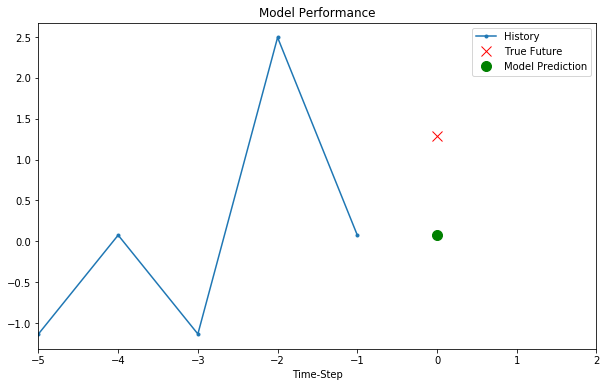

In [148]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Model Performance');

## Linear Regression

In [123]:
nfl_train = nfl_df.query('Date >= "2019-01-01"').drop(['Date', 'WinOrNot', 'HomeField'], axis = 1)
nfl_val = nfl_df.query('Date < "2019-01-01"').drop(['Date', 'WinOrNot', 'HomeField'], axis = 1)
y_train = pd.DataFrame(nfl_train['Score_Tm'])
y_val = pd.DataFrame(nfl_train['Score_Tm'])
print(nfl_train.shape, nfl_val.shape)
display.display(nfl_train.describe())
display.display(y_train.describe())
display.display(nfl_val.describe())
display.display(y_val.describe())

(532, 15) (1602, 15)


,OT,Score_Tm,Score_Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
count,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0
mean,0.0,22.8,22.8,20.3,348.0,234.4,113.6,1.4,20.3,348.0,234.4,113.6,1.4
std,0.2,10.1,10.1,5.0,88.1,79.6,53.1,1.3,5.0,88.1,79.6,53.1,1.3
min,0.0,0.0,0.0,6.0,105.0,48.0,17.0,0.0,6.0,105.0,48.0,17.0,0.0
25%,0.0,16.0,16.0,17.0,282.0,175.8,75.0,0.0,17.0,282.0,175.8,75.0,0.0
50%,0.0,23.0,23.0,20.5,347.5,233.5,106.0,1.0,20.5,347.5,233.5,106.0,1.0
75%,0.0,30.0,30.0,24.0,409.2,284.2,145.0,2.0,24.0,409.2,284.2,145.0,2.0
max,1.0,59.0,59.0,36.0,643.0,490.0,285.0,7.0,36.0,643.0,490.0,285.0,7.0


,Score_Tm
count,532.0
mean,22.8
std,10.1
min,0.0
25%,16.0
50%,23.0
75%,30.0
max,59.0


,OT,Score_Tm,Score_Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
count,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0
mean,0.1,22.7,22.7,20.0,346.3,235.6,110.7,1.4,20.0,346.3,235.6,110.7,1.4
std,0.2,10.0,10.0,5.0,84.1,77.5,50.0,1.2,5.0,84.1,77.5,50.0,1.2
min,0.0,0.0,0.0,5.0,89.0,6.0,6.0,0.0,5.0,89.0,6.0,6.0,0.0
25%,0.0,16.0,16.0,16.2,288.0,181.0,75.0,0.0,16.2,288.0,181.0,75.0,0.0
50%,0.0,23.0,23.0,20.0,344.0,231.0,103.0,1.0,20.0,344.0,231.0,103.0,1.0
75%,0.0,29.0,29.0,23.0,406.0,287.0,140.0,2.0,23.0,406.0,287.0,140.0,2.0
max,1.0,57.0,57.0,37.0,626.0,500.0,323.0,8.0,37.0,626.0,500.0,323.0,8.0


,Score_Tm
count,532.0
mean,22.8
std,10.1
min,0.0
25%,16.0
50%,23.0
75%,30.0
max,59.0


In [0]:
nfl_df = nfl_df.reindex(np.random.permutation(nfl.index))

In [0]:
def preprocess_features(nfl_df):
  """Prepares input features from nfl data.

  Args:
    nfl_df: A Pandas DataFrame expected to contain data from NFL data set.
  Returns:
    A DataFrame that contains the features to be used for model, including 
    synthetic features.
  """
  selected_features = nfl_df[['Opp', 'Offense_1stD', 'Offense_TotYd',  'Offense_PassY',	 'Offense_RushY',	'Offense_TO',	
                              'Defense_1stD', 'Defense_TotYd',	'Defense_PassY',	'Defense_RushY',	'Defense_TO']]

  processed_features = selected_features.copy()
  return processed_features

def preprocess_targets(nfl_df):
  """Prepares target features from nfl data

  Args:
     nfl_df: A Pandas DataFrame expected to contain data from NFL data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets['Score_Tm'] = nfl_df['Score_Tm']
  return output_targets


In [126]:
training_examples = preprocess_features(nfl_df.query('Date < "2019-01-01"'))
training_targets = preprocess_targets(nfl_df.query('Date < "2019-01-01"'))

validation_examples = preprocess_features(nfl_df.query('Date >= "2019-01-01"'))
validation_targets = preprocess_targets(nfl_df.query('Date >= "2019-01-01"'))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
count,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0,1602.0
mean,20.0,346.3,235.6,110.7,1.4,20.0,346.3,235.6,110.7,1.4
std,5.0,84.1,77.5,50.0,1.2,5.0,84.1,77.5,50.0,1.2
min,5.0,89.0,6.0,6.0,0.0,5.0,89.0,6.0,6.0,0.0
25%,16.2,288.0,181.0,75.0,0.0,16.2,288.0,181.0,75.0,0.0
50%,20.0,344.0,231.0,103.0,1.0,20.0,344.0,231.0,103.0,1.0
75%,23.0,406.0,287.0,140.0,2.0,23.0,406.0,287.0,140.0,2.0
max,37.0,626.0,500.0,323.0,8.0,37.0,626.0,500.0,323.0,8.0


Validation examples summary:


,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO
count,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0,532.0
mean,20.3,348.0,234.4,113.6,1.4,20.3,348.0,234.4,113.6,1.4
std,5.0,88.1,79.6,53.1,1.3,5.0,88.1,79.6,53.1,1.3
min,6.0,105.0,48.0,17.0,0.0,6.0,105.0,48.0,17.0,0.0
25%,17.0,282.0,175.8,75.0,0.0,17.0,282.0,175.8,75.0,0.0
50%,20.5,347.5,233.5,106.0,1.0,20.5,347.5,233.5,106.0,1.0
75%,24.0,409.2,284.2,145.0,2.0,24.0,409.2,284.2,145.0,2.0
max,36.0,643.0,490.0,285.0,7.0,36.0,643.0,490.0,285.0,7.0


Training targets summary:


,Score_Tm
count,1602.0
mean,22.7
std,10.0
min,0.0
25%,16.0
50%,23.0
75%,29.0
max,57.0


Validation targets summary:


,Score_Tm
count,532.0
mean,22.8
std,10.1
min,0.0
25%,16.0
50%,23.0
75%,30.0
max,59.0


In [0]:
def normalize_features(dataset):
  mu = np.mean(dataset,axis=0)
  sigma = np.std(dataset,axis=0)
  return (dataset - mu)/ sigma

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """

  categorical_columns = ['Opp']
  numeric_columns = ['Offense_1stD', 'Offense_TotYd',  'Offense_PassY',	 'Offense_RushY',	'Offense_TO',	
                    'Defense_1stD',	'Defense_TotYd', 'Defense_PassY',	'Defense_RushY',	'Defense_TO']

  feature_columns = []

  for feature_name in categorical_columns:
    vocabulary = nfl_df[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

  for feature_name in numeric_columns:
    # nfl_df[feature_name] = normalize_features(nfl_df[feature_name])
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

  return set(feature_columns)
  
  
  # return set([tf.feature_column.numeric_column(my_feature, normalizer_fn = tf.contrib.layers.batch_norm)
  #             for my_feature in input_features])


In [0]:
def my_input_fn(features, targets, batch_size = 1, shuffle = True, num_epochs = None):
  """Train a linear regression model.

  Args:
    features: pandas dataframe of features
    targets: pandas dataframe of targets
    batch_size: size of batches to be passed to the model
    shuffle: True or False. whether to shuffle the data
    num_epochs: number of epochs for which data should be repeated. 
                None = repeat indefinitely
  Returns:
    Tuple of (features, labels) for next data batch
  """

  features = {key: np.array(value) for key, value in dict(features).items()}

  ds = Dataset.from_tensor_slices((features, targets))
  ds = ds.batch(batch_size).repeat(num_epochs)

  if shuffle:
    ds = ds.shuffle(10000)

  features, labels = ds.make_one_shot_iterator().get_next()
  return features, labels


In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns, 
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Train a linear regressio model.
  Args:

  Returns:
    A `LinearRegressor` object trained on the training data
  """ 

  periods = 10
  steps_per_period = steps / periods

  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns = feature_columns,
      optimizer = my_optimizer
  )

  training_input_fn = lambda: my_input_fn(training_examples,
                                          training_targets['Score_Tm'],
                                          batch_size = batch_size
                                          )
  predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                  training_targets['Score_Tm'],
                                                  num_epochs = 1,
                                                  shuffle = False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                  validation_targets['Score_Tm'],
                                                  num_epochs = 1,
                                                  shuffle = False)  

  print('Training model:')
  print('RMSE (on training data):')
  training_rmse = []
  validation_rmse = []
  for period in range(0, periods):
    linear_regressor.train(
        input_fn = training_input_fn,
        steps = steps_per_period
    )
    
    training_result = linear_regressor.evaluate(predict_training_input_fn)

    training_predictions = linear_regressor.predict(input_fn = predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn = predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

    training_rmse_value = math.sqrt(
        metrics.mean_squared_error(training_predictions, np.array(training_targets)))
    validation_rmse_value = math.sqrt(
        metrics.mean_squared_error(validation_predictions, np.array(validation_targets)))
    
    print('training: period %02d : %.f' % (period, training_rmse_value))
    print('validation: period %02d : %.f' % (period, validation_rmse_value))
    print(training_result)
    

    training_rmse.append(training_rmse_value)
    validation_rmse.append(validation_rmse_value)

    # accuracy, accuracy_op = tf.metrics.accuracy(labels = tf.argmax(training_targets['Score_Tm'], 0), predictions=tf.argmax(training_predictions, 0))
    # with tf.Session() as sess:
    #   print(sess.run(accuracy))
  print("Model training finished.")

  plt.figure(figsize = [7,4])
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("RMSE / Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label = 'training')
  plt.plot(validation_rmse, label = 'validation')
  plt.ylabel

  return linear_regressor

Training model:
RMSE (on training data):
training: period 00 : 22
validation: period 00 : 22
{'average_loss': 478.83853, 'label/mean': 22.652933, 'loss': 478.83853, 'prediction/mean': 3.060702, 'global_step': 10}
training: period 01 : 19
validation: period 01 : 19
{'average_loss': 363.74008, 'label/mean': 22.652933, 'loss': 363.74008, 'prediction/mean': 6.1212053, 'global_step': 20}
training: period 02 : 16
validation: period 02 : 17
{'average_loss': 267.94937, 'label/mean': 22.652933, 'loss': 267.94937, 'prediction/mean': 9.180711, 'global_step': 30}
training: period 03 : 14
validation: period 03 : 14
{'average_loss': 191.48866, 'label/mean': 22.652933, 'loss': 191.48866, 'prediction/mean': 12.239062, 'global_step': 40}
training: period 04 : 12
validation: period 04 : 12
{'average_loss': 134.38426, 'label/mean': 22.652933, 'loss': 134.38426, 'prediction/mean': 15.287757, 'global_step': 50}
training: period 05 : 10
validation: period 05 : 10
{'average_loss': 96.448616, 'label/mean': 22

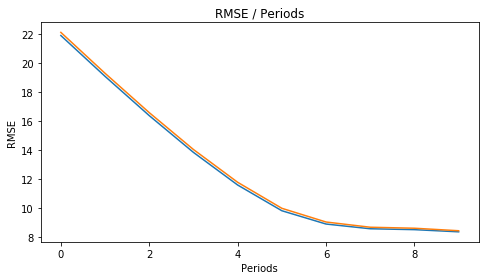

In [131]:
lm = train_model(
    learning_rate = 0.0001,
    steps = 100,
    batch_size = 20,
    feature_columns = construct_feature_columns(training_examples), 
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
 )

## Prediction

In [132]:
next_game

,Opp,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Defense_1stD,Defense_TotYd,Defense_PassY,Defense_RushY,Defense_TO,Score_Tm
0,Kansas City Chiefs,17.0,283.0,146.0,137.0,1.0,20.0,309.0,146.0,53.0,2.0,10
1,San Francisco 49ers,20.0,309.0,256.0,53.0,2.0,17.0,283.0,256.0,137.0,1.0,10


In [133]:
feature = preprocess_features(next_game)
target = preprocess_targets(next_game)
feature_columns = construct_feature_columns(feature)


predict_test_input_fn = lambda: my_input_fn(feature,
                                            target['Score_Tm'],
                                            num_epochs = 1,
                                            shuffle = False)
  
predictions = lm.predict(input_fn = predict_test_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])


for pred in enumerate(predictions):    
    print(pred)


(0, 17.98227)
(1, 20.722195)
